# House Pricing - Regression
By Alejandro Parrado Di Doménico

## Context
The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978.

## Attribute Information
### Input features in order:
1) CRIM: per capita crime rate by town
2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3) INDUS: proportion of non-retail business acres per town
4) CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5) NOX: nitric oxides concentration (parts per 10 million) [parts/10M]
6) RM: average number of rooms per dwelling
7) AGE: proportion of owner-occupied units built prior to 1940
8) DIS: weighted distances to five Boston employment centres
9) RAD: index of accessibility to radial highways
10) TAX: full-value property-tax rate per $10,000 [$/10k]
11) PTRATIO: pupil-teacher ratio by town
12) B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13) LSTAT: % lower status of the population

### Output variable:
1) MEDV: Median value of owner-occupied homes in $1000's [k$]

---

##  Checklist

### 🔍 Step 1: Load & Inspect

* Load into Pandas (`pd.read_csv` if CSV, or `sklearn.datasets.load_boston()` if using sklearn, though it’s deprecated).
* Check:

  * `.head()` → first rows.
  * `.info()` → datatypes, nulls.
  * `.describe()` → quick stats.

👉 Goal: **know what you’re dealing with**.

---

### 🧹 Step 2: Data Cleaning

* **Missing values?** Handle them (impute mean/median, drop rows).
* **Data types:** Convert categorical/dummy variables properly (e.g., `CHAS` is binary, not numeric continuous).
* **Outliers:** Use boxplots/histograms to see if extreme values skew results.

---

### 📊 Step 3: Exploratory Data Analysis (EDA)

This is where you **play detective**:

* **Target variable (`MEDV`) distribution:** Is it skewed? (Spoiler: it’s capped at 50 → check for that).
* **Feature distributions:** Plot histograms for each (crime rate, rooms, etc.).
* **Correlation heatmap:** `df.corr()` + seaborn heatmap → find which features are most related to `MEDV`.

  * Example: `RM` (rooms) is strongly positive, `LSTAT` (lower status %) is strongly negative.
* **Pairplots/scatterplots:** Plot `MEDV` vs `RM`, `LSTAT`, `CRIM` to visually see relationships.

---

### 🛠 Step 4: Feature Engineering

* Normalize/standardize numerical features if scales are very different (crime rate vs rooms).
* Encode categorical features (`CHAS`).
* Optionally create interaction terms (e.g., `RM*LSTAT`) if you want to experiment.

---

### 🧪 Step 5: Split Data

* Train/test split (e.g., 80/20).
* Don’t touch the test set until final evaluation.

---

### 🚀 Step 6: Baseline Model

* Start stupid simple: **Linear Regression**.
* Fit, predict, evaluate with:

  * **MSE** (mean squared error)
  * **RMSE** (root MSE)
  * **R² score**

---

### 🎯 Step 7: Refinement

* Try removing weakly correlated features → check performance.
* Compare models: Linear Regression vs Ridge vs Lasso.
* Check residual plots → are errors randomly distributed? (good) or patterned (bad model fit)?

## Import packages

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


## Load & Inspect Dataset

In [4]:
df_hp = pd.read_csv('boston.csv')
df_hp.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


I can already identify that the features will require some type of normalization, because they have very different ranges and magnitudes

In [5]:
# Getting some information about the dataset (features, datatypes, nulls, etc.)
df_hp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


Here I can see that there are **not** null values, also that all the types are numerical, most of them floats and a couple integers

In [6]:
df_hp.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


This information could be useful for later normalization or simply to understand better the data

## EDA (Exploratory Data Analysis)

In [7]:
# Count null values (already done before but just to have it more visible)
df_hp.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

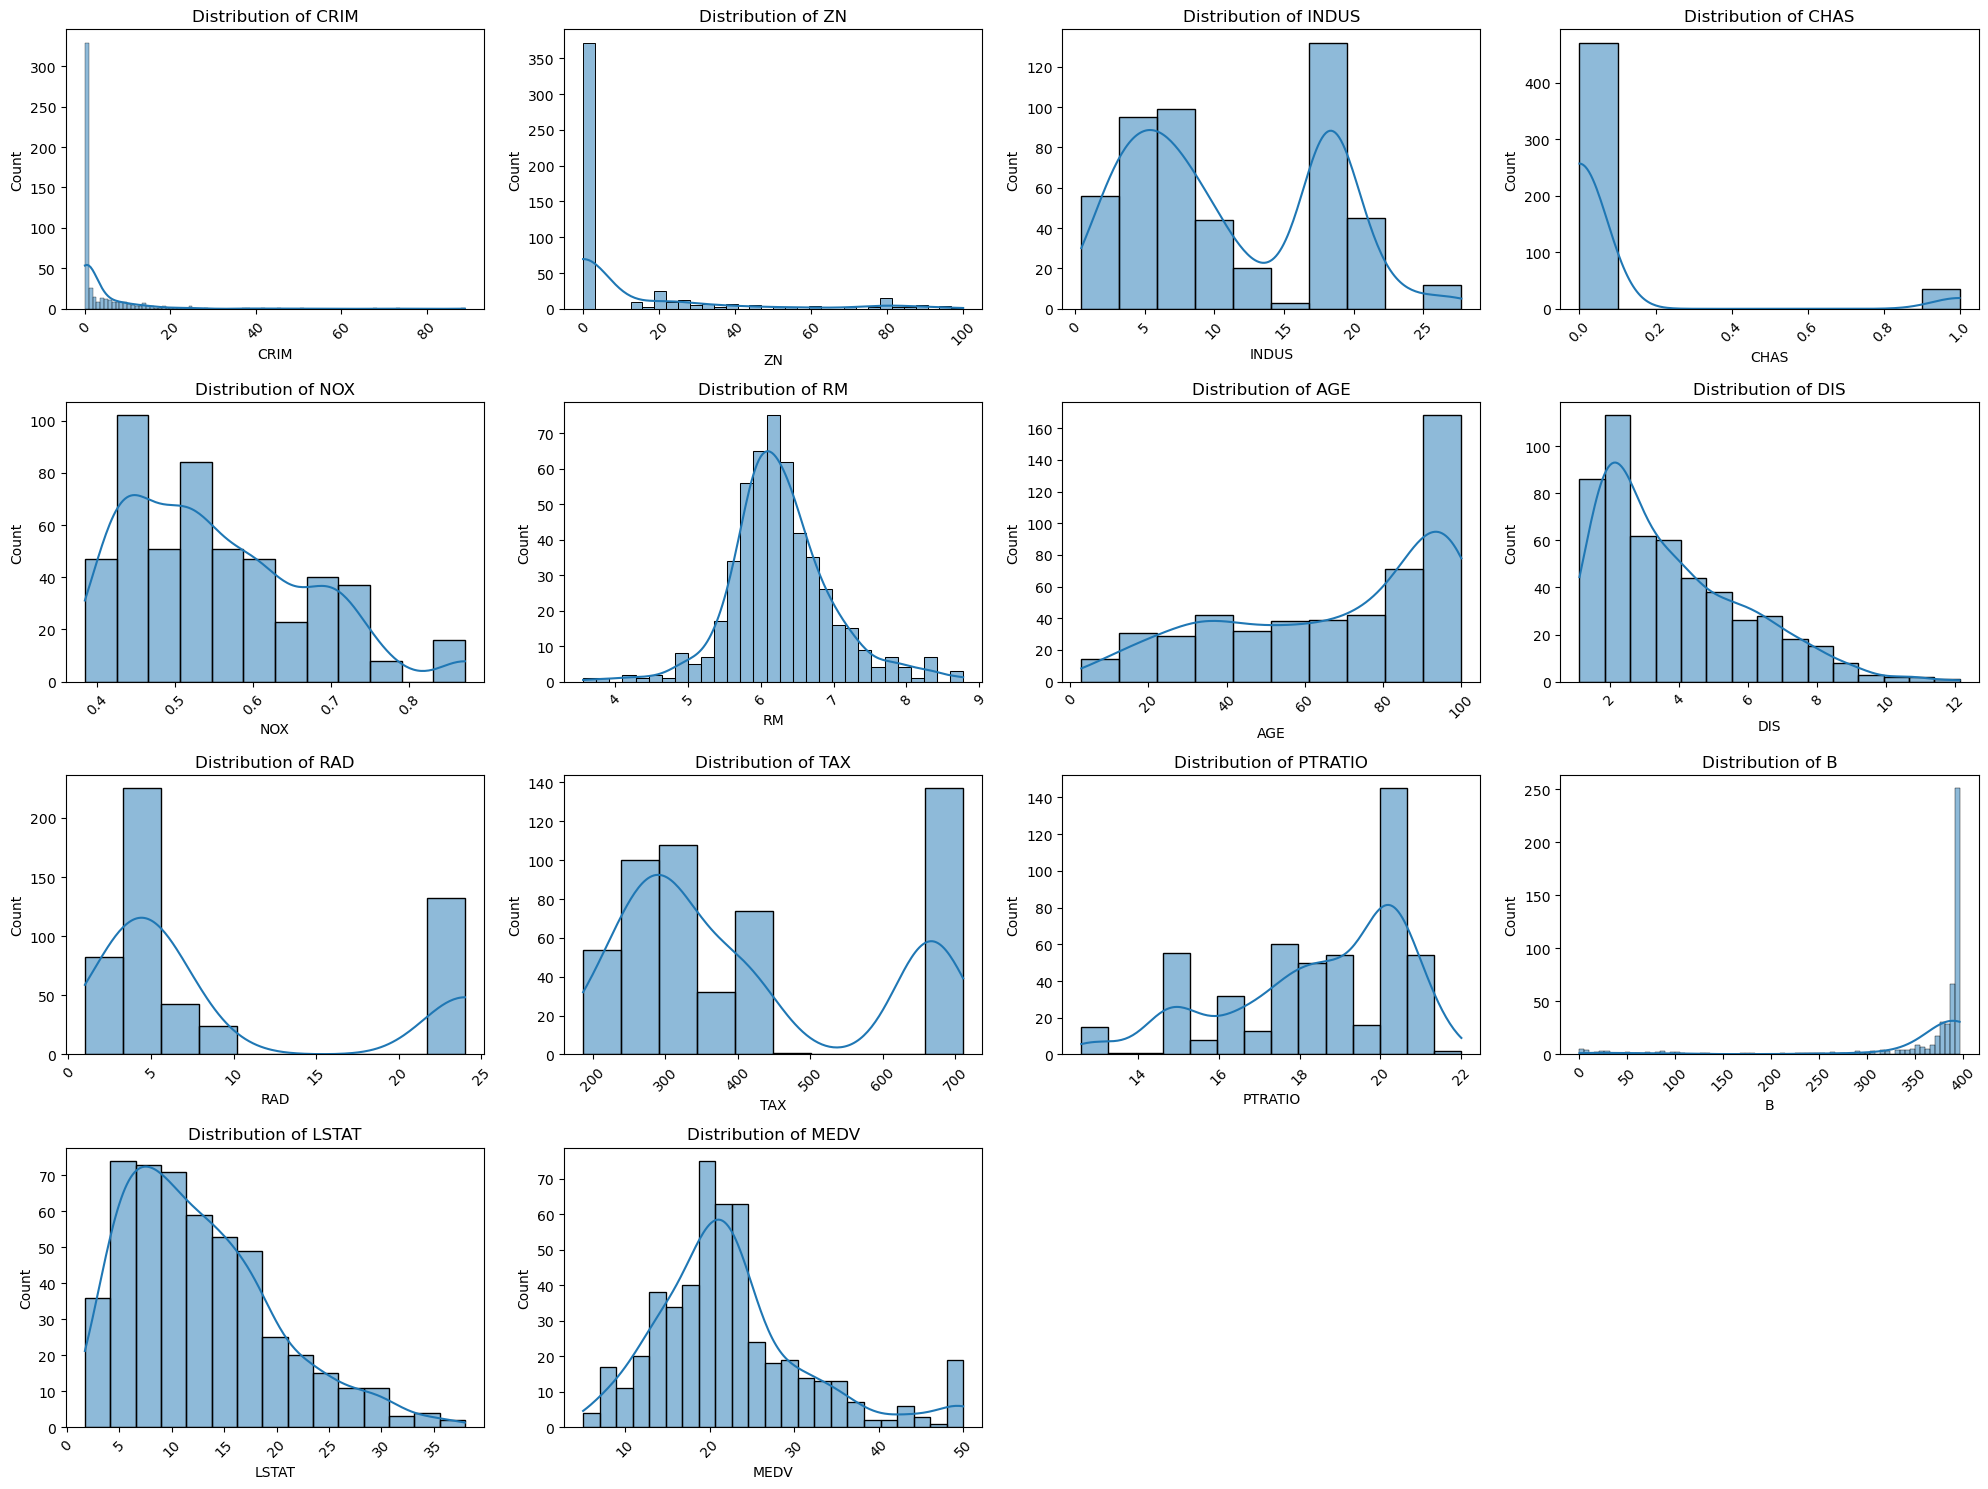

In [8]:
# Create a figure with multiple subplots for histograms
plt.figure(figsize=(20, 15))

# Plot histogram for each feature
for idx, column in enumerate(df_hp.columns, 1):
    plt.subplot(4, 4, idx)
    sns.histplot(data=df_hp, x=column, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


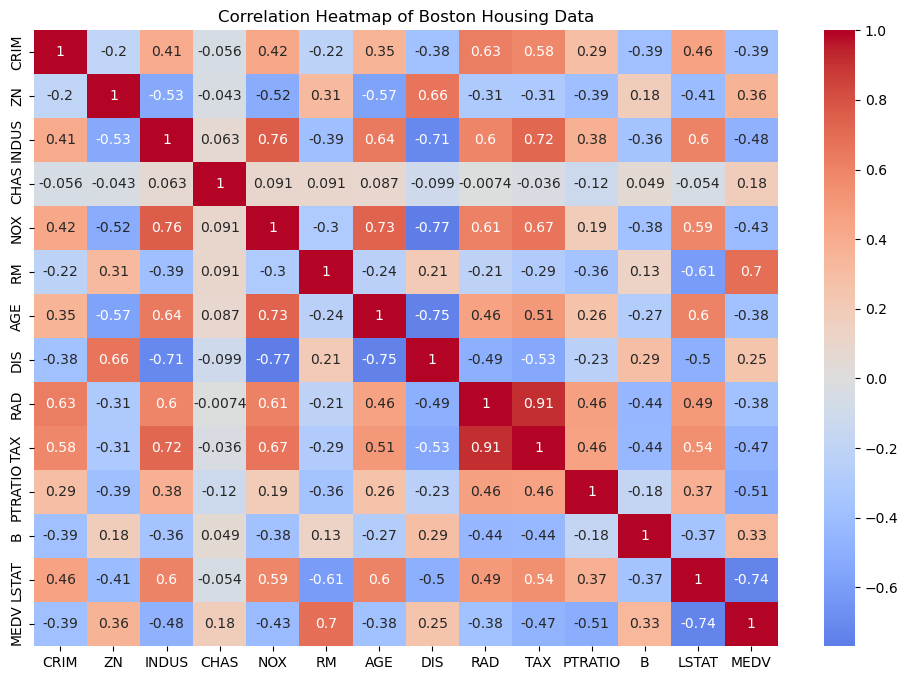

In [9]:
# Seaborn heatmap for correlation
plt.figure(figsize=(12, 8))
sns.heatmap(df_hp.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Boston Housing Data')
plt.show()

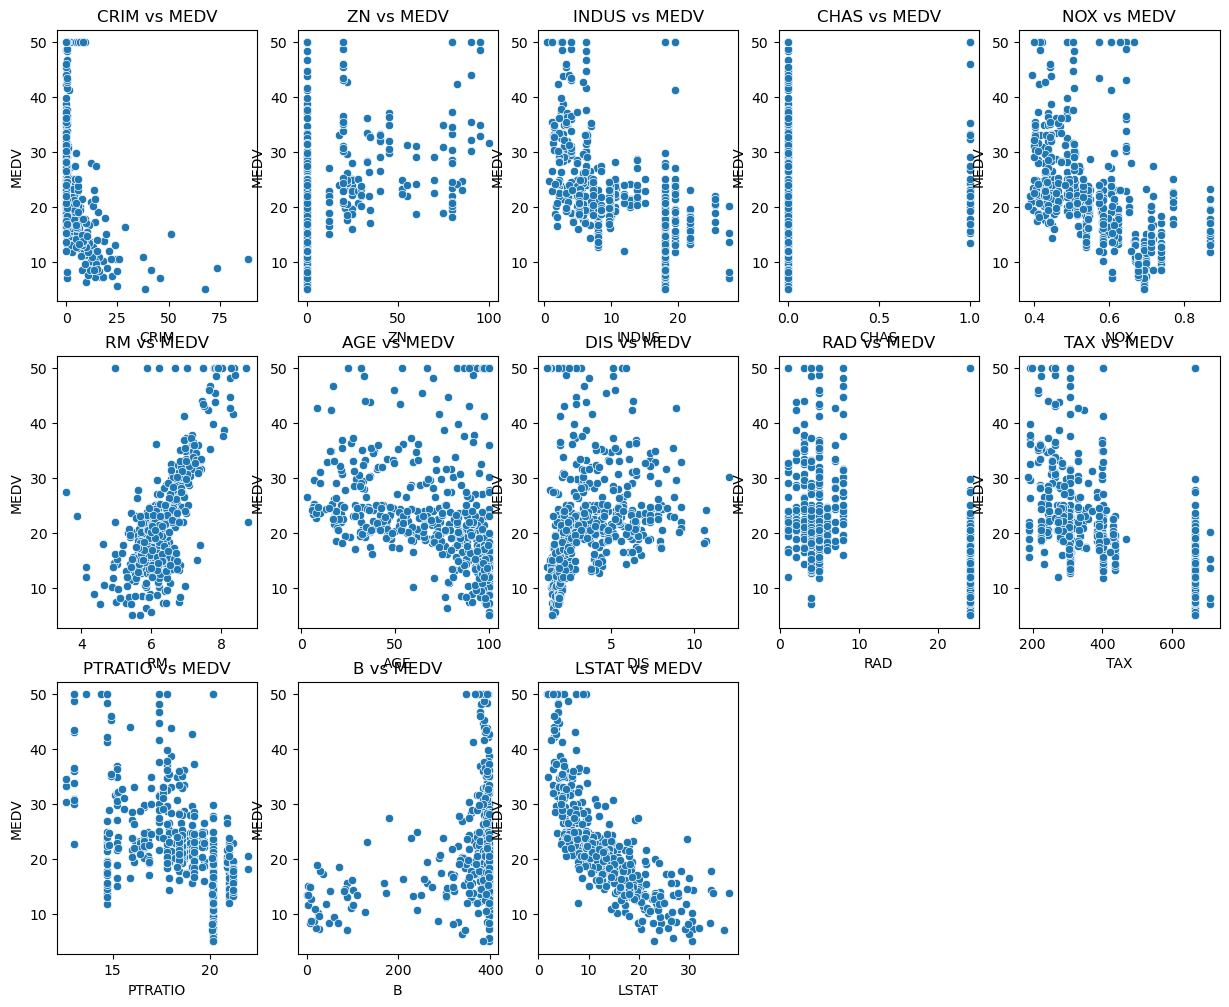

In [10]:
# Pairplots for visualizing relationships between features and target
plt.figure(figsize=(15, 12))

for i, col in enumerate(df_hp.columns[:-1]):
    plt.subplot(3, 5, i + 1)
    sns.scatterplot(x=col, y='MEDV', data=df_hp)
    plt.title(f'{col} vs MEDV')
    plt.xlabel(col)
    plt.ylabel('MEDV')


It's clear there's a strong linear relationship between RM-MEDV and LSTAT-MEDV, so both are good candidates to create a single-feature prediction model

## Simple models

### Split training/test data

In [11]:
y = df_hp['MEDV']
x = df_hp.drop(columns=['MEDV'])

print('Target variable (MEDV):')
print(y.head())
print('\nFeatures:')
print(x.head())

Target variable (MEDV):
0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: MEDV, dtype: float64

Features:
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33  


In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Show the split
print("\nTraining set:")
print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

print("\nTesting set:")
print(f"X_test shape: {x_test.shape}")



Training set:
X_train shape: (404, 13)
y_train shape: (404,)

Testing set:
X_test shape: (102, 13)


### RM-MEDV
Linear regression model to predict a house value from it's rooms per dwelling

Model intercept (b): -218.0913469159347
Model coefficients (w):
  w[0]: 4.1217915309504575e-07
  w[1]: -7.25310963988143
  w[2]: 0.6578157778164186
  w[3]: -4.721435456381289
  w[4]: 36.77012712857372
  w[5]: 285.82332612636185
  w[6]: 17.876717276700436
  w[7]: 0.6574684671467096
  w[8]: -4.062431984956811
  w[9]: 2.6348893791416033
  w[10]: 0.0022792023606291742
  w[11]: 7.654169243159858
  w[12]: 0.13895862818115093
  w[13]: -0.19399251817270546
  w[14]: 0.00040481314865054886
  w[15]: 0.07879600352842295
  w[16]: 0.5606828859430141
  w[17]: 2.5774320015588392
  w[18]: -2.032321802041681
  w[19]: 0.18860993066345602
  w[20]: -0.0021559746599324843
  w[21]: -0.0743944840389778
  w[22]: 0.31283148438141894
  w[23]: -0.03565024697199434
  w[24]: 0.6525694521612773
  w[25]: -0.0004208609358217555
  w[26]: 0.033117808672150306
  w[27]: -0.0004393611426920588
  w[28]: -0.004907844934367772
  w[29]: -0.04135173092387402
  w[30]: -1.3681335026988437
  w[31]: -0.0035244312286875357
  w[32]: 

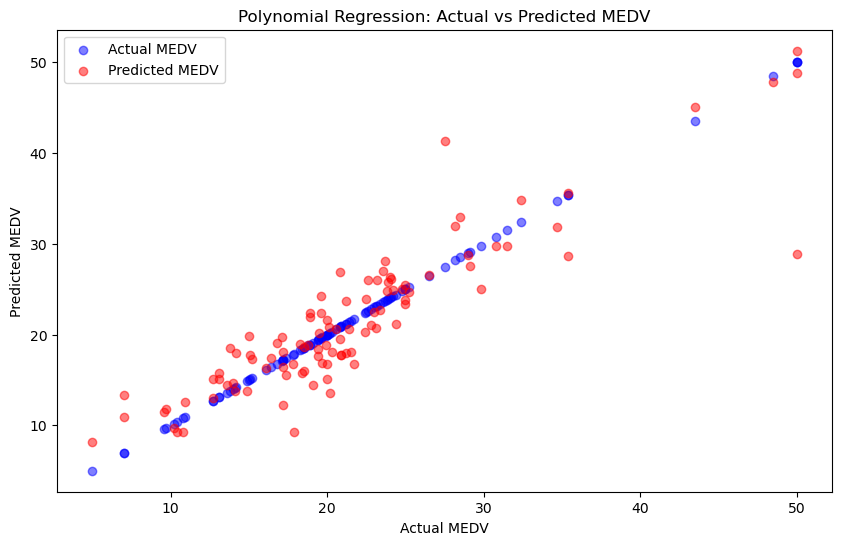

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Create a polynomial regression model of degree 2
poly_degree = 2
poly_model = make_pipeline(PolynomialFeatures(degree=poly_degree), LinearRegression())

# Fit the model to the training data
poly_model.fit(x_train, y_train)

# Show model information
linreg = poly_model.named_steps['linearregression']
coefs = linreg.coef_
intercept = linreg.intercept_

print("Model intercept (b):", intercept)
print("Model coefficients (w):")
for i, coef in enumerate(coefs):
    print(f"  w[{i}]: {coef}")

# Make predictions on the test set
y_pred = poly_model.predict(x_test)

# Calculate the R-squared score
r2_score(y_test, y_pred)

# Plot the results
plt.figure(figsize=(10, 6))
# Plot actual values as blue dots along the y=x line
plt.scatter(y_test, y_test, color='blue', alpha=0.5, label='Actual MEDV')
# Plot predicted values as red dots at (y_test, y_pred)
plt.scatter(y_test, y_pred, color='red', alpha=0.5, label='Predicted MEDV')
plt.xlabel('Actual MEDV')
plt.ylabel('Predicted MEDV')
plt.title('Polynomial Regression: Actual vs Predicted MEDV')
plt.legend()


In [14]:
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate accuracy as percentage: 100% - (MAE / mean of actual values) * 100
accuracy_percentage = 100 - (mae / y_test.mean()) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Model accuracy (based on MAE): {accuracy_percentage:.2f}%")


Mean Absolute Error (MAE): 2.57
Model accuracy (based on MAE): 88.02%
